In [1]:
# Importaciones estándar
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocesamiento y evaluación
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos de machine learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Modelos avanzados
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Utilidades adicionales
import joblib
from scipy.optimize import minimize

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

2025-08-19 17:16:46.063155: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 17:16:46.377228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_ve

In [2]:
def is_prime(x):
    if x < 2:
        return False
    if x == 2:
        return True
    if x % 2 == 0:
        return False
    
    for i in range(3, int(x**0.5) + 1, 2):
        if x % i == 0:
            return False
    return True

In [3]:
def get_repetidos(row):
    if row.name == len(melate_df) - 1:  # Última fila no tiene siguiente
        return {'NUMEROS_REPETIDOS': [], 'TOTAL_REPETIDOS': 0}
    
    # Obtener números del sorteo actual
    nums_actual = set(row[['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']])
    
    # Obtener números del sorteo siguiente
    nums_siguiente = set(melate_df.loc[row.name + 1, ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']])
    
    # Encontrar números comunes (repetidos del siguiente sorteo)
    comunes = list(nums_actual & nums_siguiente)
    
    return {'NUMEROS_REPETIDOS': comunes, 'TOTAL_REPETIDOS': len(comunes)}

In [4]:
data_dir = Path('data')

if not data_dir.exists():
    print("El directorio 'data' no existe")
else:
    csv_files = list(data_dir.glob('*.csv'))
    if csv_files:
        print("\nArchivos CSV encontrados:")
        for csv in csv_files:
            print(f"- {csv.name} (Tamaño: {csv.stat().st_size / 1024:.2f} KB)")
    else:
        print("\nNo hay archivos CSV en 'data'")


Archivos CSV encontrados:
- 20250819_revancha.csv (Tamaño: 138.83 KB)
- 20250819_melate.csv (Tamaño: 193.43 KB)
- Melate_pakin.csv (Tamaño: 123.64 KB)


In [5]:
melate_df = pd.read_csv("data/20250819_melate.csv")
melate_df['ganador'] = 0

melate_df['FECHA'] = pd.to_datetime(melate_df['FECHA'], format = "%d/%m/%Y")
melate_df = melate_df[melate_df['FECHA'] >= '2008-01-01']

In [6]:
# 5. Comparar premios consecutivos
for i in range(0, len(melate_df)):
    if i == 0:
        pass
    
    elif melate_df.loc[i, 'BOLSA'] > melate_df.loc[i-1, 'BOLSA']:
        melate_df.loc[i, 'ganador'] = 1  

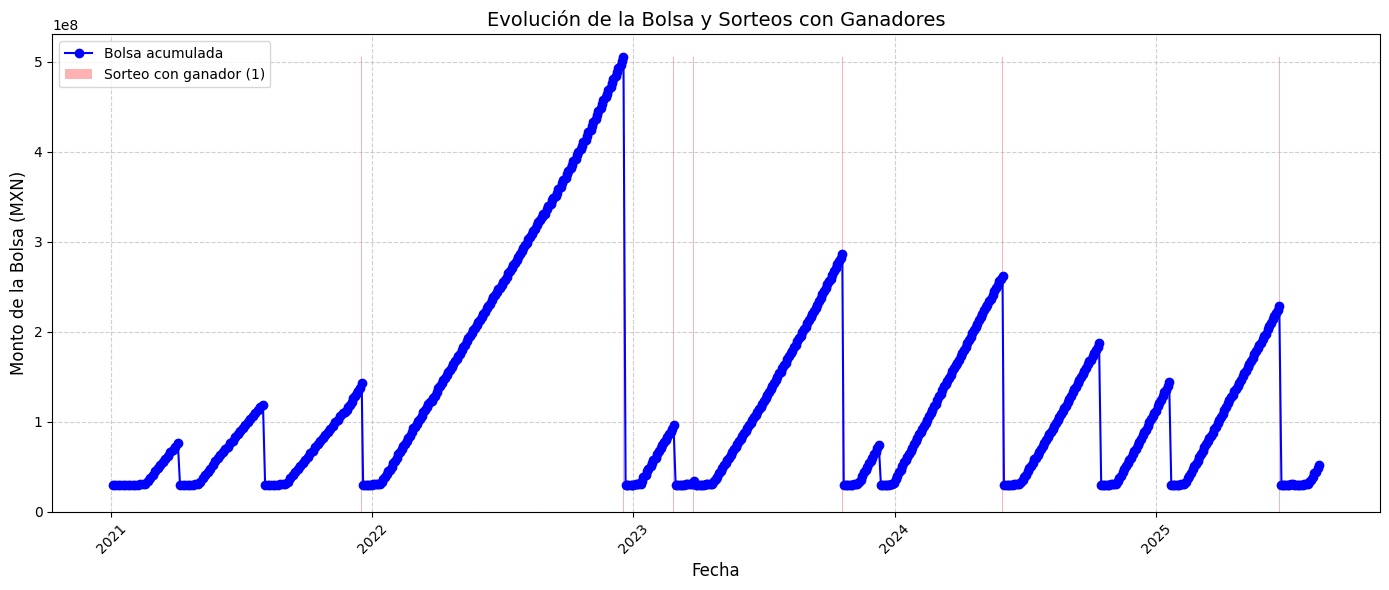

In [ ]:
# Crear figura
plt.figure(figsize=(14, 6))

mask_fecha = melate_df['FECHA'] >= '2021-01-01'

# 1. Gráfico de línea para la BOLSA (eje Y izquierdo)
plt.plot(melate_df['FECHA'][mask_fecha], melate_df['BOLSA'][mask_fecha], 
         label='Bolsa acumulada', marker='o', color='blue', linestyle='-')

# 2. Gráfico de barras para GANADOR (eje Y derecho)
plt.bar(melate_df['FECHA'][mask_fecha], 
        melate_df['ganador'][mask_fecha] * melate_df['BOLSA'][mask_fecha].max(),
        color='red', 
        alpha=0.3, 
        label='Sorteo con ganador (1)')

# Personalización
plt.title('Evolución de la Bolsa y Sorteos con Ganadores', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Monto de la Bolsa (MXN)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Rotar fechas para mejor legibilidad
plt.xticks(rotation=45)

# Guardar y mostrar
plt.tight_layout()
plt.savefig('data/bolsa_vs_ganadores.png', dpi=300)
plt.show()

In [7]:
melate_df['SUM1'] = melate_df['R1'] + melate_df['R2'] + melate_df['R3'] + melate_df['R4'] + melate_df['R5'] + melate_df['R6']
melate_df['MEDIA1'] = (melate_df['SUM1'] / 6).round(2)

melate_df['SUM2'] = melate_df['R1'] + melate_df['R2'] + melate_df['R3'] + melate_df['R4'] + melate_df['R5'] + melate_df['R6'] + melate_df['R7']
melate_df['MEDIA2'] = (melate_df['SUM2'] / 6).round(2)

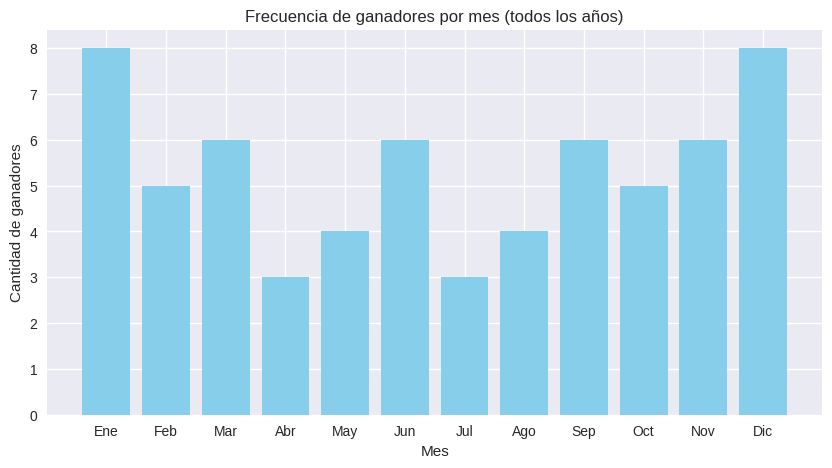

In [8]:
# Filtrar solo ganadores
ganadores = melate_df[melate_df['ganador'] == 1].copy()

# Extraer mes
ganadores['MES'] = ganadores['FECHA'].dt.month

# Contar cantidad de ganadores por mes
frecuencia_mes = ganadores.groupby('MES').size()

# Gráfico de barras simple
plt.figure(figsize=(10,5))
plt.bar(frecuencia_mes.index, frecuencia_mes.values, color='skyblue')
plt.xticks(range(1,13), 
           ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
plt.xlabel("Mes")
plt.ylabel("Cantidad de ganadores")
plt.title("Frecuencia de ganadores por mes (todos los años)")
plt.show()

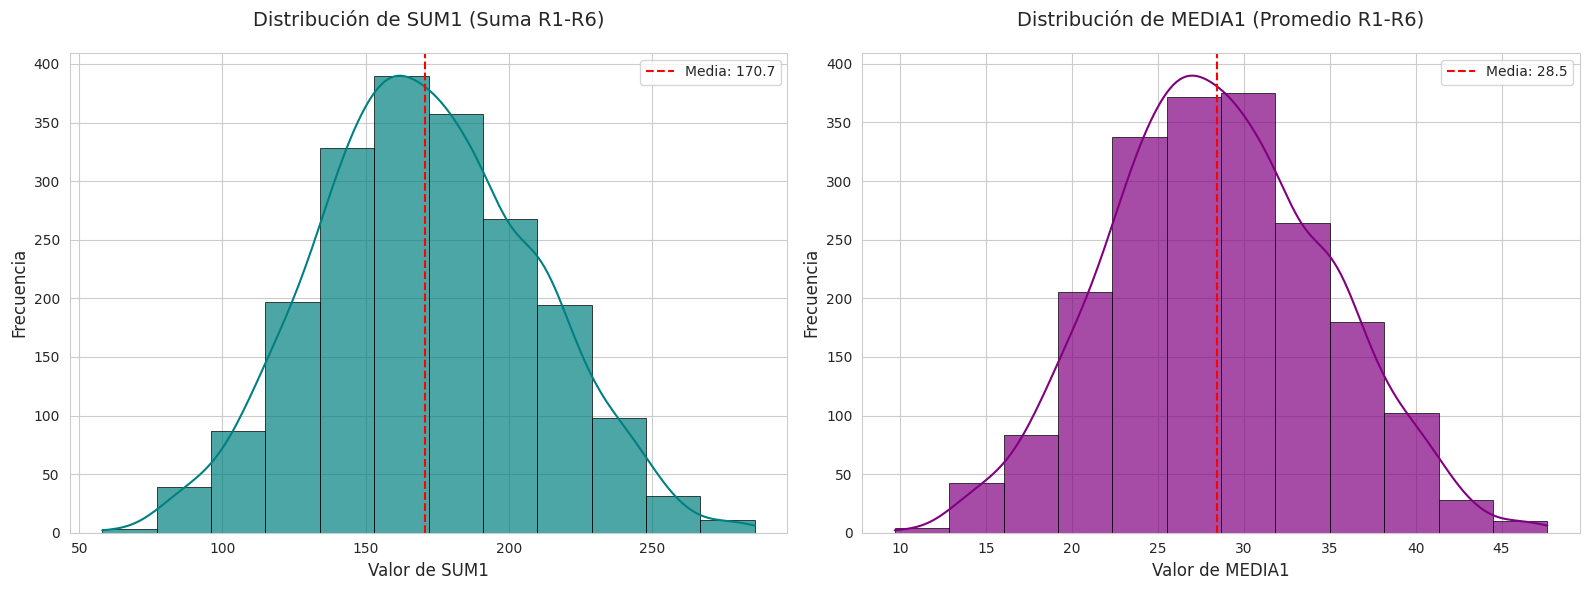

In [10]:
# Configuración inicial
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# --- Gráfico 1: Distribución de SUM1 ---
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
sns.histplot(melate_df['SUM1'], 
             bins=12, 
             kde=True, 
             color='teal',
             edgecolor='black',
             linewidth=0.5,
             alpha=0.7)
plt.title('Distribución de SUM1 (Suma R1-R6)', fontsize=14, pad=20)
plt.xlabel('Valor de SUM1', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir línea de media
plt.axvline(melate_df['SUM1'].mean(), 
            color='red', 
            linestyle='--', 
            label=f'Media: {melate_df["SUM1"].mean():.1f}')
plt.legend()

# --- Gráfico 2: Distribución de MEDIA1 ---
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
sns.histplot(melate_df['MEDIA1'], 
             bins=12, 
             kde=True, 
             color='purple',
             edgecolor='black',
             linewidth=0.5,
             alpha=0.7)
plt.title('Distribución de MEDIA1 (Promedio R1-R6)', fontsize=14, pad=20)
plt.xlabel('Valor de MEDIA1', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir línea de media
plt.axvline(melate_df['MEDIA1'].mean(), 
            color='red', 
            linestyle='--', 
            label=f'Media: {melate_df["MEDIA1"].mean():.1f}')
plt.legend()

# Ajustes finales
plt.tight_layout()
plt.savefig('distribucion_sum1_media1.png', dpi=300)
plt.show()

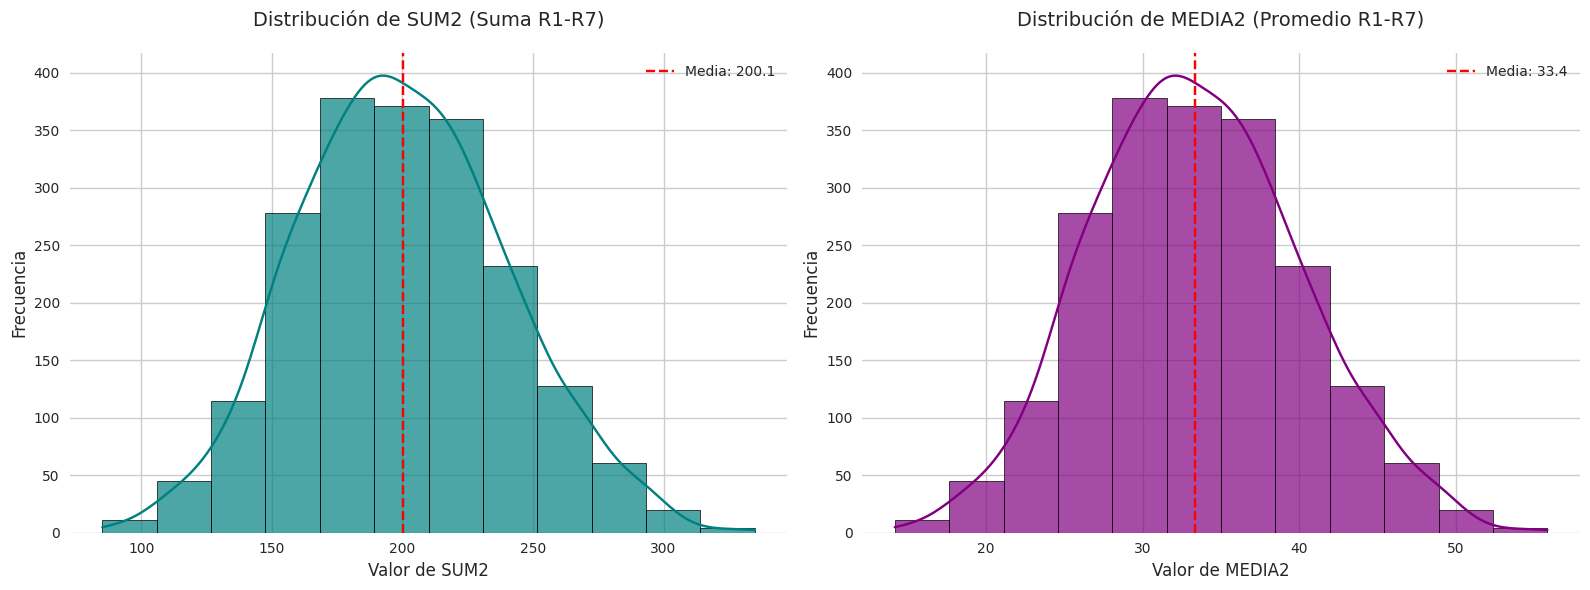

In [9]:
# Configuración inicial
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# --- Gráfico 1: Distribución de SUM2 ---
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
sns.histplot(melate_df['SUM2'], 
             bins=12, 
             kde=True, 
             color='teal',
             edgecolor='black',
             linewidth=0.5,
             alpha=0.7)
plt.title('Distribución de SUM2 (Suma R1-R7)', fontsize=14, pad=20)
plt.xlabel('Valor de SUM2', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir línea de media
plt.axvline(melate_df['SUM2'].mean(), 
            color='red', 
            linestyle='--', 
            label=f'Media: {melate_df["SUM2"].mean():.1f}')
plt.legend()

# --- Gráfico 2: Distribución de MEDIA2 ---
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
sns.histplot(melate_df['MEDIA2'], 
             bins=12, 
             kde=True, 
             color='purple',
             edgecolor='black',
             linewidth=0.5,
             alpha=0.7)
plt.title('Distribución de MEDIA2 (Promedio R1-R7)', fontsize=14, pad=20)
plt.xlabel('Valor de MEDIA2', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir línea de media
plt.axvline(melate_df['MEDIA2'].mean(), 
            color='red', 
            linestyle='--', 
            label=f'Media: {melate_df["MEDIA2"].mean():.1f}')
plt.legend()

# Ajustes finales
plt.tight_layout()
plt.savefig('distribucion_sum2_media2.png', dpi=300)
plt.show()

In [10]:
# Agrupar por 'ganador' y calcular estadísticas
stats = melate_df.groupby('ganador')[['SUM1', 'MEDIA1']].agg(['mean', 'std', 'count'])
print(stats)

               SUM1                      MEDIA1                
               mean        std count       mean       std count
ganador                                                        
0        170.797318  37.868324  1939  28.466184  6.311318  1939
1        168.875000  37.159245    64  28.145937  6.193293    64


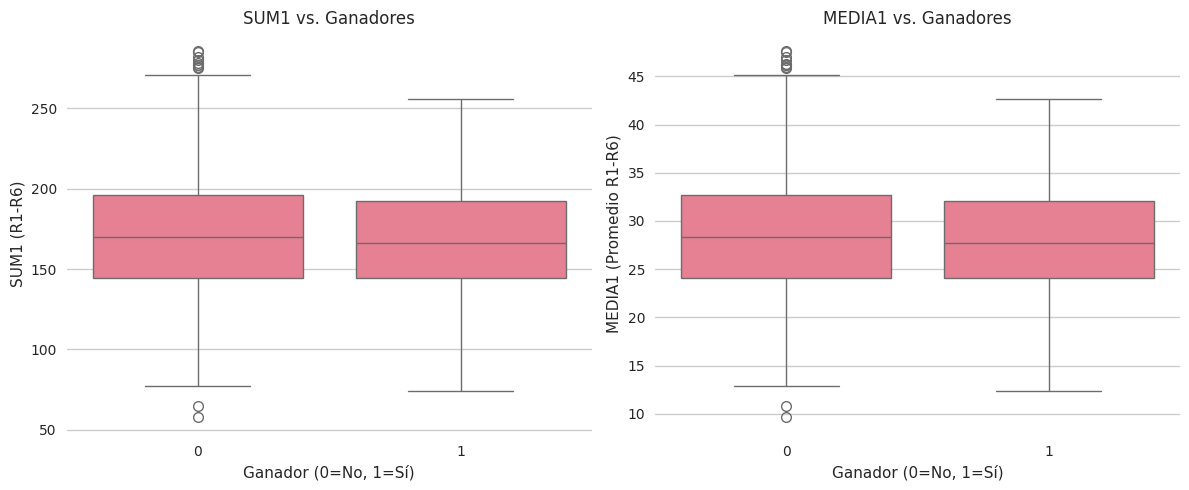

In [11]:
plt.figure(figsize=(12, 5))

# Boxplot para SUM1
plt.subplot(1, 2, 1)
sns.boxplot(data=melate_df, x='ganador', y='SUM1')
plt.title('SUM1 vs. Ganadores')
plt.xlabel('Ganador (0=No, 1=Sí)')
plt.ylabel('SUM1 (R1-R6)')

# Boxplot para MEDIA1
plt.subplot(1, 2, 2)
sns.boxplot(data=melate_df, x='ganador', y='MEDIA1')
plt.title('MEDIA1 vs. Ganadores')
plt.xlabel('Ganador (0=No, 1=Sí)')
plt.ylabel('MEDIA1 (Promedio R1-R6)')

plt.tight_layout()
plt.show()

In [12]:
melate_df['TOTAL_PRIMOS'] = melate_df.apply(
    lambda row: sum(is_prime(row[f'R{i}']) for i in range(1, 7)), 
    axis=1
)

In [13]:
resultados = melate_df.apply(get_repetidos, axis=1, result_type='expand')
melate_df[['NUMEROS_REPETIDOS', 'TOTAL_REPETIDOS']] = resultados

In [14]:
melate_df.head(2)

,NPRODUCTO,CONCURSO,R1,R2,R3,R4,R5,R6,R7,BOLSA,FECHA,ganador,SUM1,MEDIA1,SUM2,MEDIA2,TOTAL_PRIMOS,NUMEROS_REPETIDOS,TOTAL_REPETIDOS
0,40,4097,7,28,39,40,41,54,29,52300000,2025-08-17,0,209,34.83,238,39.67,2,[],0
1,40,4096,2,18,32,44,48,55,3,48700000,2025-08-15,0,199,33.17,202,33.67,1,"[32, 18]",2


In [15]:
# Suponiendo que tienes un DataFrame con columnas R1 a R7
numeros = pd.concat([melate_df[f'R{i}'] for i in range(1, 8)])

# Contar frecuencia de cada número
frecuencia_numeros = numeros.value_counts().sort_index()

In [16]:
print(f"\nNúmero más frecuente: {frecuencia_numeros.idxmax()} (aparece {frecuencia_numeros.max()} veces)")
print(f"Número menos frecuente: {frecuencia_numeros.idxmin()} (aparece {frecuencia_numeros.min()} veces)")
print(f"Frecuencia promedio: {frecuencia_numeros.mean():.2f} veces por número")


Número más frecuente: 29 (aparece 280 veces)
Número menos frecuente: 7 (aparece 227 veces)
Frecuencia promedio: 250.38 veces por número


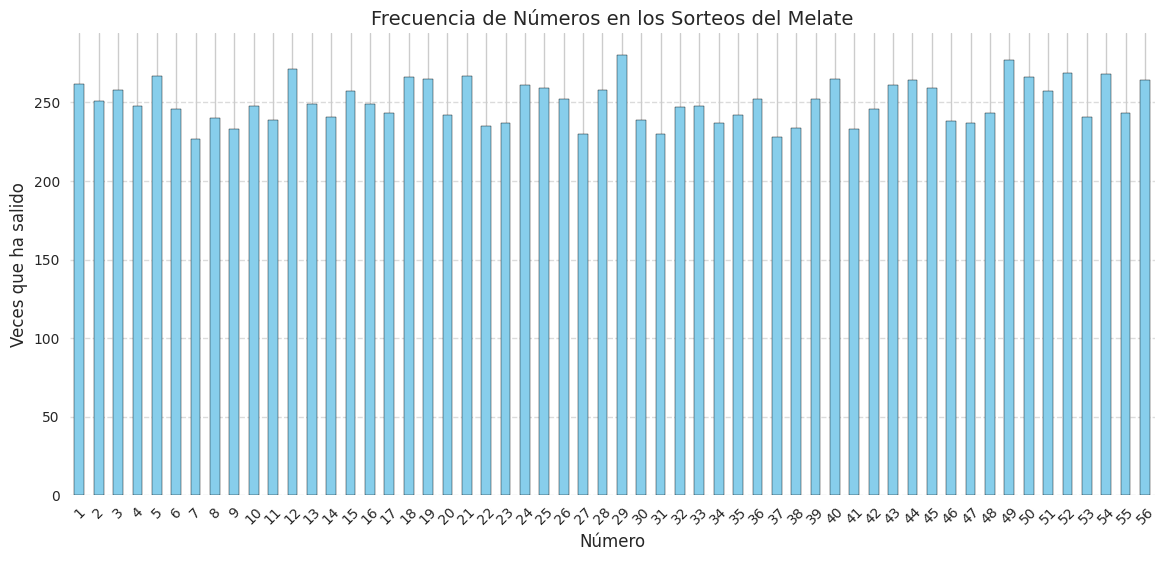

In [17]:
plt.figure(figsize=(14, 6))
frecuencia_numeros.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia de Números en los Sorteos del Melate', fontsize=14)
plt.xlabel('Número', fontsize=12)
plt.ylabel('Veces que ha salido', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Números calientes (top 10 más frecuentes)
calientes = frecuencia_numeros.nlargest(7)
print("\nTop 7 números calientes:")
print(calientes)

# Números fríos (top 10 menos frecuentes)
frios = frecuencia_numeros.nsmallest(7)
print("\nTop 7 números fríos:")
print(frios)


Top 7 números calientes:
29    280
49    277
12    271
52    269
54    268
5     267
21    267
Name: count, dtype: int64

Top 7 números fríos:
7     227
37    228
27    230
31    230
9     233
41    233
38    234
Name: count, dtype: int64


In [ ]:
def calcular_estadisticas(fila):
    """
    Calcula características estadísticas de un sorteo de lotería
    """
    # Obtener los 6 números principales
    numeros = np.array([fila['R1'], fila['R2'], fila['R3'], fila['R4'], fila['R5'], fila['R6']])
    
    # Calcular estadísticas (CORREGIDO: is_prime para cada número individual)
    stats = np.array([
        np.sum(numeros),                    # Suma total
        np.mean(numeros),                   # Promedio
        np.std(numeros),                    # Desviación estándar
        np.max(numeros) - np.min(numeros),  # Rango
        np.median(numeros),                 # Mediana
        len([n for n in numeros if n % 2 == 0]),  # Cantidad de pares
        len([n for n in numeros if n % 2 != 0]),  # Cantidad de impares
        sum(1 for n in numeros if is_prime(n)),  # Cantidad de primos
        fila['TOTAL_REPETIDOS']            # Repetidos del sorteo anterior
    ])
    
    return stats


In [46]:
# 1. Crear secuencias de números (solo los 6 números principales)
numeros = melate_df[['R1', 'R2', 'R3', 'R4', 'R5', 'R6']].values

# 2. Normalizar datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
numeros_normalizados = scaler.fit_transform(numeros)

In [47]:

# 3. Crear secuencias para el modelo (X = entrada, y = salida)
X, y = [], []

look_back = 14  # Usar 14 sorteos anteriores para predecir el siguiente

for i in range(len(numeros_normalizados) - look_back):
    # Entrada: números normalizados de los últimos 'look_back' sorteos
    X.append(numeros_normalizados[i:i + look_back])
    
    # Salida: características estadísticas del sorteo siguiente
    next_stats = calcular_estadisticas(melate_df.iloc[i + look_back])
    y.append(next_stats)

X = np.array(X)
y = np.array(y)

print(f"Forma de X: {X.shape}")  # (muestras, look_back, 6)
print(f"Forma de y: {y.shape}")  # (muestras, 9) - 9 características estadísticas

# Ejemplo de las características que se predicen:
print("\nCaracterísticas a predecir:")
print("1. Suma total")
print("2. Promedio")
print("3. Desviación estándar")
print("4. Rango")
print("5. Mediana")
print("6. Cantidad de pares")
print("7. Cantidad de impares")
print("8. Total de primos")
print("9. Total de repetidos")

Forma de X: (1989, 14, 6)
Forma de y: (1989, 9)

Características a predecir:
1. Suma total
2. Promedio
3. Desviación estándar
4. Rango
5. Mediana
6. Cantidad de pares
7. Cantidad de impares
8. Total de primos
9. Total de repetidos


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(1591, 14, 6), y=(1591, 9)
Test shapes: X=(398, 14, 6), y=(398, 9)


In [73]:
# Reformatear datos para modelos tradicionales
X_2d = X.reshape(X.shape[0], -1)  # (muestras, 14*6 = 84 features)
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train 2d shapes: X={X_train_2d.shape}, y={y_train.shape}")
print(f"Test 2d shapes: X={X_test_2d.shape}, y={y_test.shape}")

# Mantener también datos 3D para LSTM
X_train_3d, X_test_3d, _, __ = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train 3d shapes: X={X_train_3d.shape}, y={y_train.shape}")
print(f"Test 3d shapes: X={X_test_3d.shape}, y={y_test.shape}")

Train 2d shapes: X=(1591, 84), y=(1591, 9)
Test 2d shapes: X=(398, 84), y=(398, 9)
Train 3d shapes: X=(1591, 14, 6), y=(1591, 9)
Test 3d shapes: X=(398, 14, 6), y=(398, 9)


# Opción 1: Modelo LSTM

In [59]:
def create_lstm_model(input_shape, output_dim):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units = 64,
             activation='relu',
             return_sequences=True),   
        Dropout(0.2),
        LSTM(units = 32,
             activation='relu',
             return_sequences=False),
        Dropout(0.2),
        Dense(units = 32,
              activation='relu'),
        Dense(output_dim)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# Crear y entrenar el modelo
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2597.3833 - mae: 29.5341 - val_loss: 532.3763 - val_mae: 13.1312
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 525.9199 - mae: 13.9201 - val_loss: 308.2635 - val_mae: 8.0938
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 368.1218 - mae: 11.2028 - val_loss: 342.0847 - val_mae: 8.7330
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 325.5548 - mae: 10.3340 - val_loss: 235.1338 - val_mae: 7.4752
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 289.5615 - mae: 9.6026 - val_loss: 296.8388 - val_mae: 8.3830
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 270.2217 - mae: 8.9668 - val_loss: 267.8747 - val_mae: 7.8246
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 256.7820 - mae: 8.6133 - val_loss: 229.0342 - val_mae: 7.1167
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 240.7223 - mae: 8.2262 - val_loss: 215.3224 - val_mae: 7.0708
Epoch 9/100
50/50 

# Entrenar Modelos Base Individuales

In [75]:
# 1. XGBoost
xgb_model = MultiOutputRegressor(XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
))

# 2. LightGBM (más rápido que XGBoost)
lgbm_model = MultiOutputRegressor(LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
))

# 3. Random Forest
rf_model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
))

# 4. Gradient Boosting
gb_model = MultiOutputRegressor(GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
))

# 5. Support Vector Machine (con kernel RBF)
svm_model = MultiOutputRegressor(SVR(
    kernel='rbf',
    C=1.0,
    epsilon=0.1
))

# Entrenar todos los modelos base
print("Entrenando modelos base...")
xgb_model.fit(X_train_2d, y_train)
lgbm_model.fit(X_train_2d, y_train)
rf_model.fit(X_train_2d, y_train)
gb_model.fit(X_train_2d, y_train)
svm_model.fit(X_train_2d, y_train)  # SVM puede ser lento con muchos datos

Entrenando modelos base...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 1591, number of used features: 84
[LightGBM] [Info] Start training from score 170.431804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,estimator,SVR()
,n_jobs,None
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200


# Crear Meta-Features para el Stacking

In [76]:
def create_meta_features(models, X):
    """
    Crea predicciones de todos los modelos como meta-features
    """
    meta_features = []
    
    for model in models:
        y_pred = model.predict(X)
        meta_features.append(y_pred)
    
    # Concatenar todas las predicciones
    return np.hstack(meta_features)

In [77]:
# Crear meta-features del training set
models = [xgb_model, lgbm_model, rf_model, gb_model, svm_model]
X_meta_train = create_meta_features(models, X_train_2d)

# Crear meta-features del test set
X_meta_test = create_meta_features(models, X_test_2d)

print(f"Meta-features shape: {X_meta_train.shape}")  # (muestras, 9*5 = 45)

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
 

Meta-features shape: (1591, 45)


In [80]:
from scipy.optimize import minimize

def ensemble_loss(weights, predictions, true_values):
    """
    Función de pérdida para optimizar pesos del ensemble
    """
    weighted_pred = np.zeros_like(true_values)
    for i, weight in enumerate(weights):
        weighted_pred += weight * predictions[i]
    
    return mean_absolute_error(true_values, weighted_pred)

# Recolectar todas las predicciones
all_predictions = [
    xgb_model.predict(X_test_2d),
    lgbm_model.predict(X_test_2d),
    rf_model.predict(X_test_2d),
    gb_model.predict(X_test_2d),
    svm_model.predict(X_test_2d),
    lstm_model.predict(X_test_3d)
]

# Optimizar pesos
initial_weights = np.ones(len(all_predictions)) / len(all_predictions)
bounds = [(0, 1) for _ in range(len(all_predictions))]
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(
    ensemble_loss,
    initial_weights,
    args=(all_predictions, y_test),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)

optimized_weights = result.x
print("Pesos optimizados:", optimized_weights)

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Pesos optimizados: [1.52057438e-17 5.51567241e-02 4.32776345e-01 2.36613838e-17
 5.12066931e-01 2.96907030e-18]


In [82]:
print(f"X_train_2d shape: {X_train_2d.shape}")
print(f"X_test_2d shape: {X_test_2d.shape}")

X_train_2d shape: (1591, 84)
X_test_2d shape: (398, 84)


In [85]:
class LotteryEnsemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        self.model_types = []  # Trackear tipo de cada modelo
    
    def predict(self, X_2d, X_3d=None):
        predictions = []
        
        for i, model in enumerate(self.models):
            # Determinar tipo de modelo
            if hasattr(model, 'predict_proba') or hasattr(model, 'feature_importances_'):
                # Tree-based models (esperan X_2d)
                pred = model.predict(X_2d)
                self.model_types.append('tree')
            elif hasattr(model, 'layers'):  
                # LSTM (espera X_3d)
                if X_3d is not None:
                    pred = model.predict(X_3d)
                else:
                    pred = np.zeros((X_2d.shape[0], 9))
                self.model_types.append('lstm')
            else:
                # Otros modelos (asumir tree-based)
                try:
                    pred = model.predict(X_2d)
                    self.model_types.append('tree')
                except:
                    # Si falla, usar zeros
                    pred = np.zeros((X_2d.shape[0], 9))
                    self.model_types.append('unknown')
            
            predictions.append(pred)
        
        # Combinar con pesos optimizados
        final_pred = np.zeros_like(predictions[0])
        for i, (weight, pred) in enumerate(zip(self.weights, predictions)):
            final_pred += weight * pred
        
        return final_pred

# Crear ensemble con modelos específicos
best_models = [xgb_model, lgbm_model, rf_model, lstm_model]

# Asegurarse que los pesos están normalizados (sumen 1)
optimized_weights_normalized = optimized_weights[:4] / np.sum(optimized_weights[:4])

ensemble = LotteryEnsemble(best_models, optimized_weights_normalized)

# Predecir CORRECTAMENTE
y_pred_ensemble = ensemble.predict(X_test_2d, X_test_3d)

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [86]:
# Calcular métricas para todos los modelos
models_performance = {}

for name, y_pred in [
    ('XGBoost', xgb_model.predict(X_test_2d)),
    ('LightGBM', lgbm_model.predict(X_test_2d)),
    ('Random Forest', rf_model.predict(X_test_2d)),
    ('LSTM', lstm_model.predict(X_test_3d)),
    ('Ensemble Final', y_pred_ensemble)
]:
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    models_performance[name] = {'MAE': mae, 'MSE': mse}

# Mostrar resultados
print("Comparativa de Modelos:")
for model, metrics in models_performance.items():
    print(f"{model:15} - MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}")

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Comparativa de Modelos:
XGBoost         - MAE: 6.4745, MSE: 202.5088
LightGBM        - MAE: 6.3733, MSE: 193.6484
Random Forest   - MAE: 6.2313, MSE: 188.8758
LSTM            - MAE: 7.9396, MSE: 305.8323
Ensemble Final  - MAE: 6.2349, MSE: 188.3154


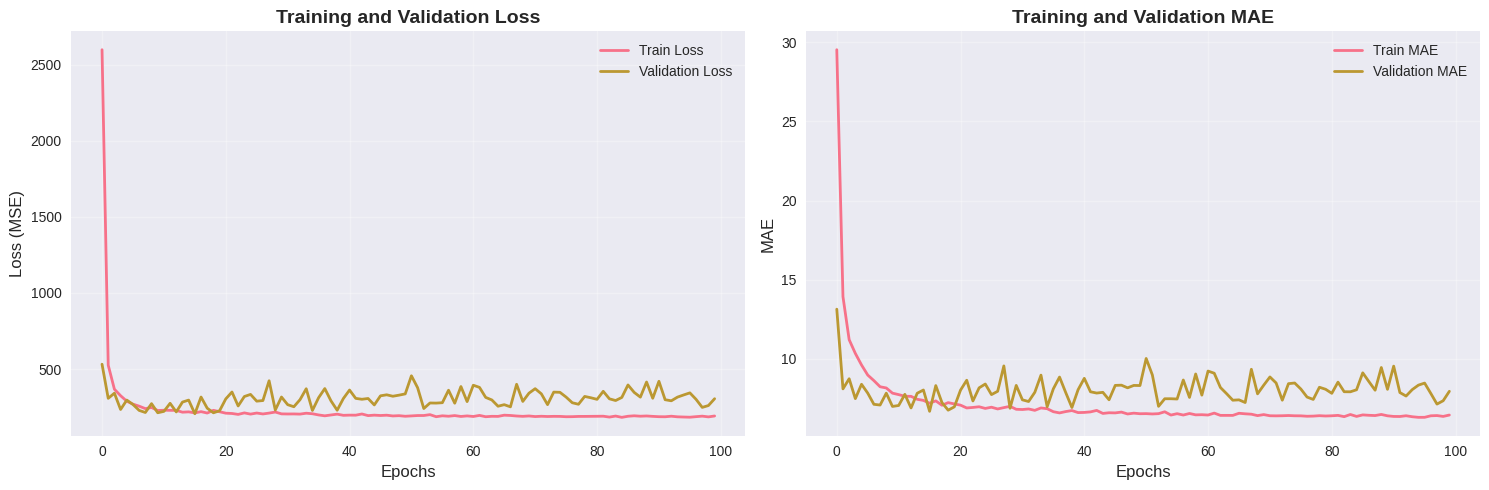

In [89]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE
    ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usar
plot_training_history(history)

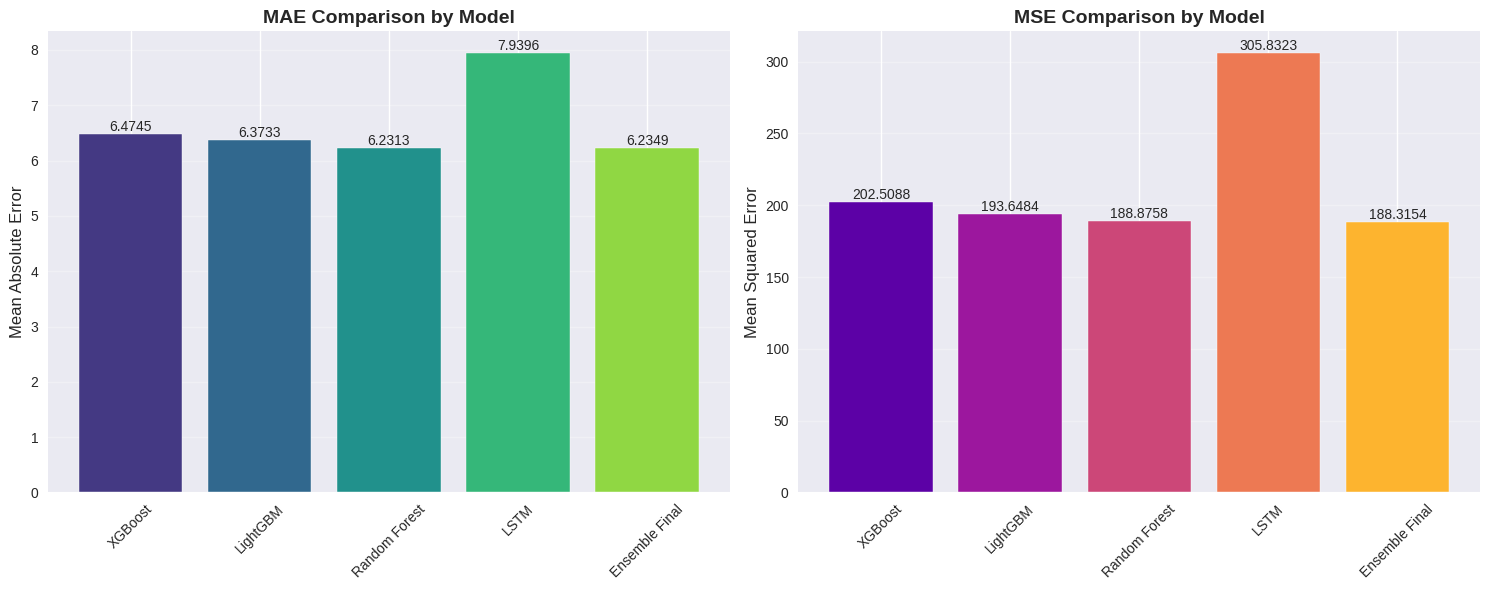

In [90]:
def plot_model_comparison(models_performance):
    models = list(models_performance.keys())
    mae_values = [metrics['MAE'] for metrics in models_performance.values()]
    mse_values = [metrics['MSE'] for metrics in models_performance.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # MAE Comparison
    bars1 = ax1.bar(models, mae_values, color=sns.color_palette("viridis", len(models)))
    ax1.set_title('MAE Comparison by Model', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom')
    
    # MSE Comparison
    bars2 = ax2.bar(models, mse_values, color=sns.color_palette("plasma", len(models)))
    ax2.set_title('MSE Comparison by Model', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean Squared Error', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Usar
plot_model_comparison(models_performance)

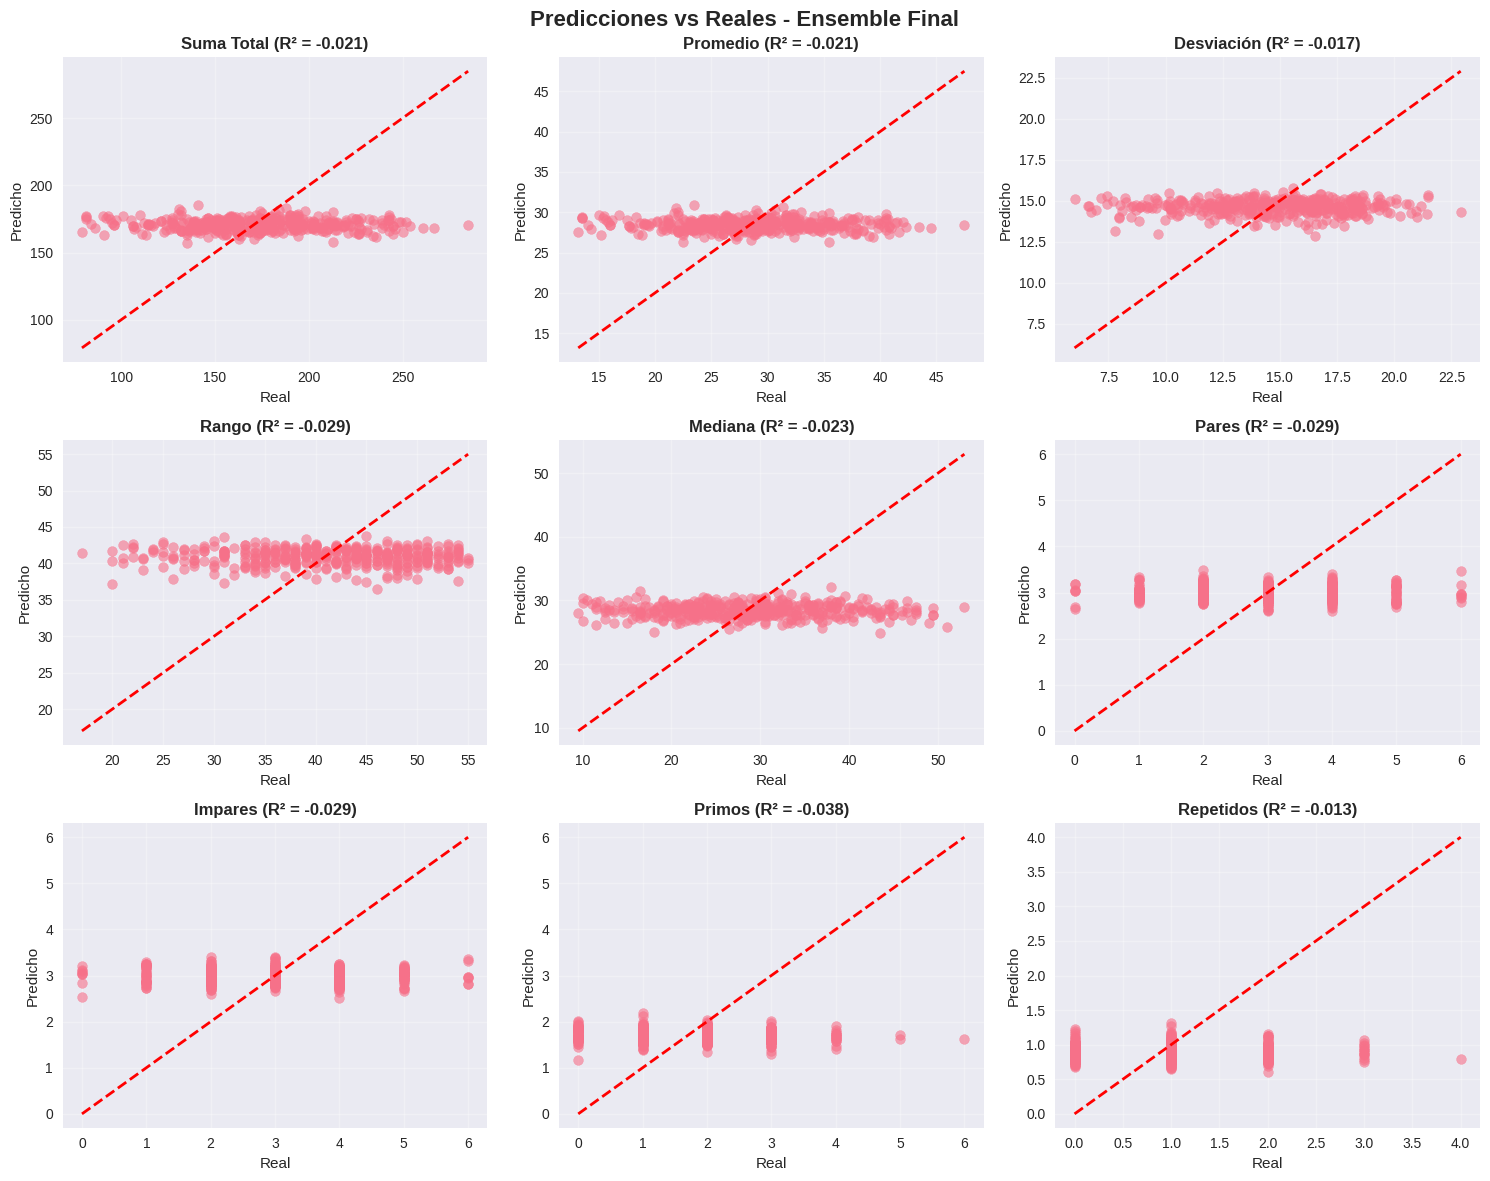

In [91]:
def plot_predictions_vs_real(y_true, y_pred, model_name, feature_names):
    n_features = y_true.shape[1]
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(n_features):
        if i < len(axes):
            ax = axes[i]
            ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, s=50)
            
            # Línea perfecta (y=x)
            min_val = min(y_true[:, i].min(), y_pred[:, i].min())
            max_val = max(y_true[:, i].max(), y_pred[:, i].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            
            r2 = r2_score(y_true[:, i], y_pred[:, i])
            ax.set_title(f'{feature_names[i]} (R² = {r2:.3f})', fontweight='bold')
            ax.set_xlabel('Real')
            ax.set_ylabel('Predicho')
            ax.grid(True, alpha=0.3)
    
    # Ocultar ejes vacíos
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Predicciones vs Reales - {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Nombres de las características
feature_names = [
    'Suma Total', 'Promedio', 'Desviación', 'Rango', 'Mediana',
    'Pares', 'Impares', 'Primos', 'Repetidos'
]

# Usar para el mejor modelo
plot_predictions_vs_real(y_test, y_pred_ensemble, 'Ensemble Final', feature_names)

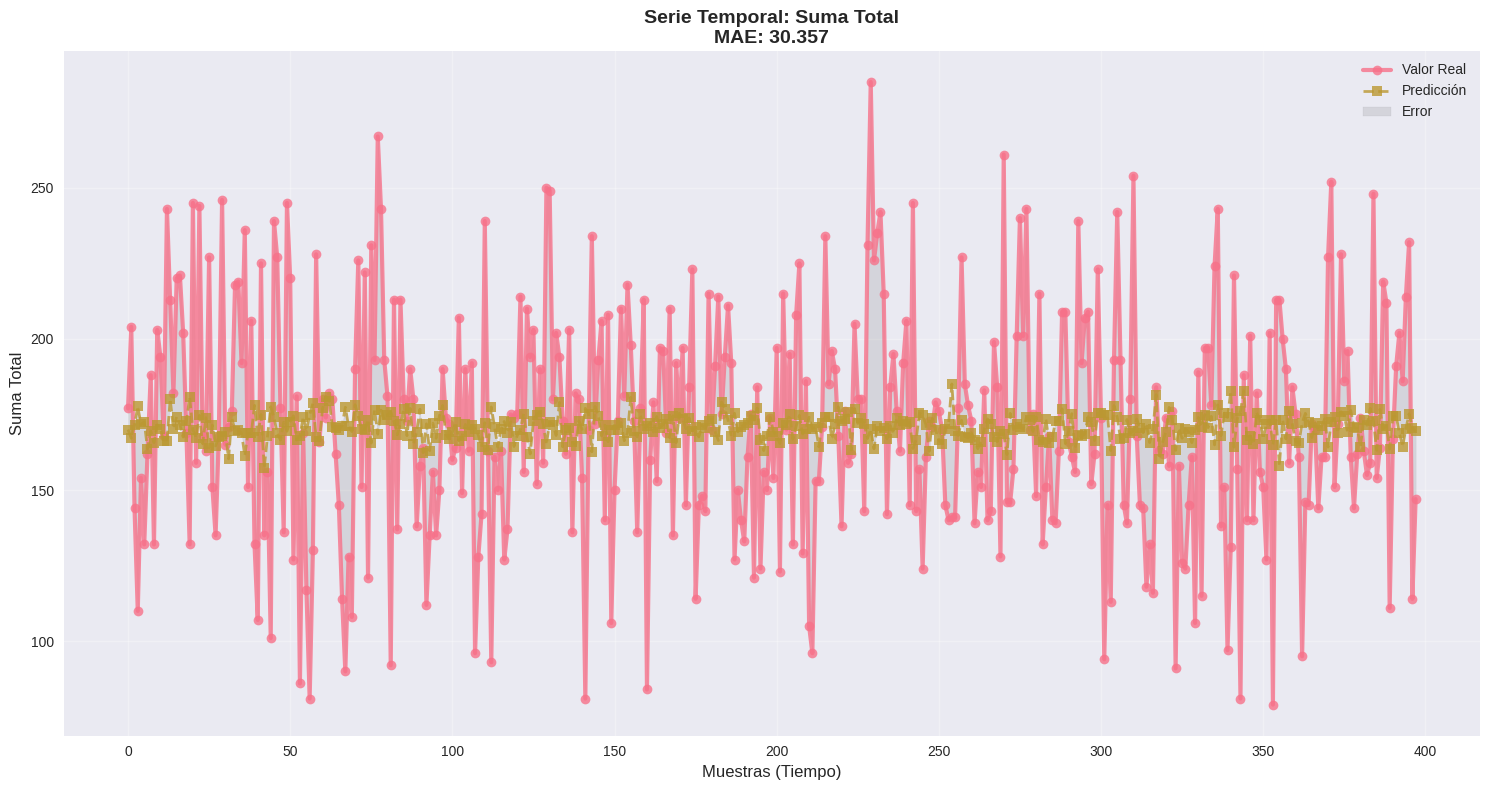

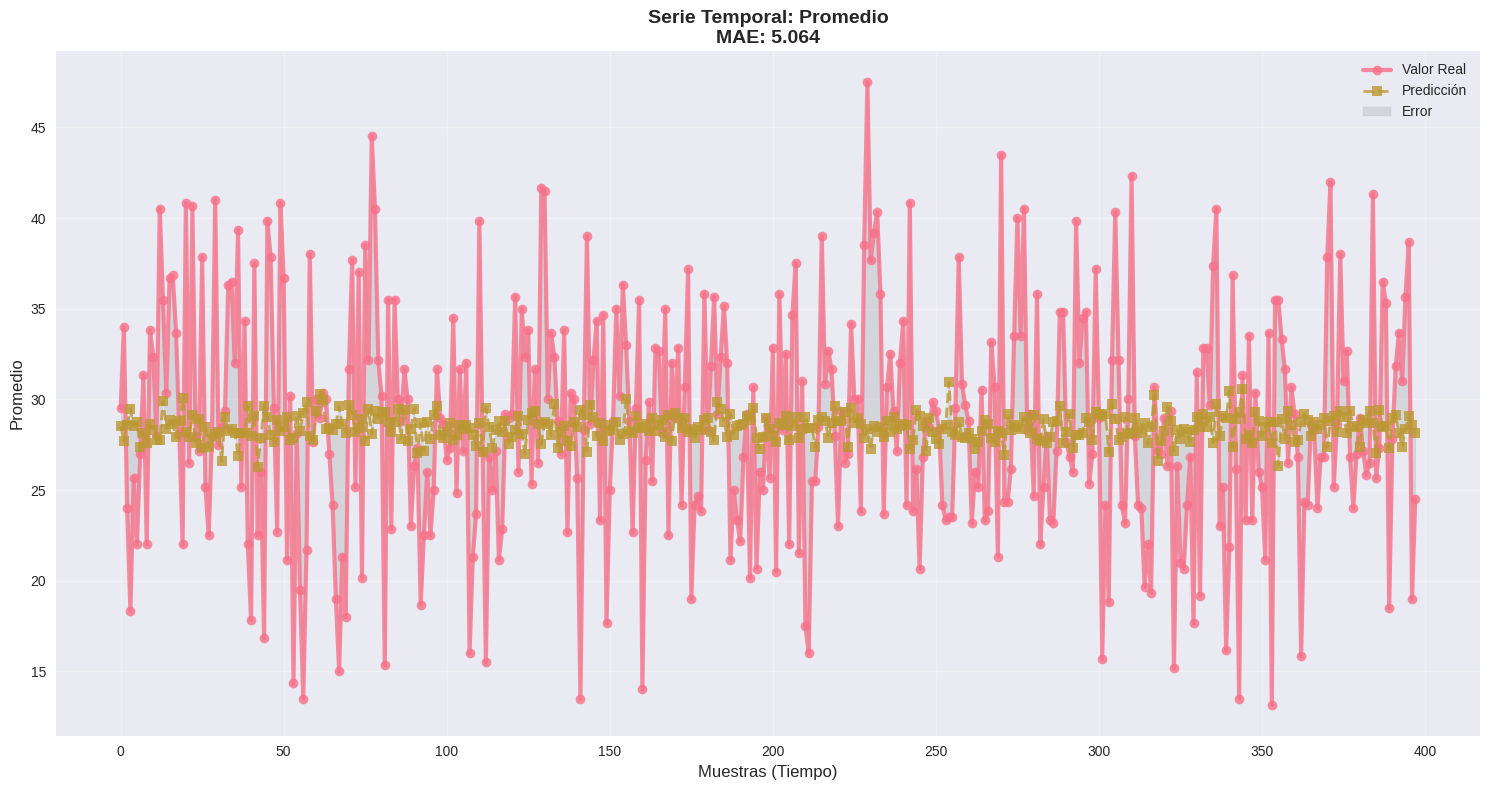

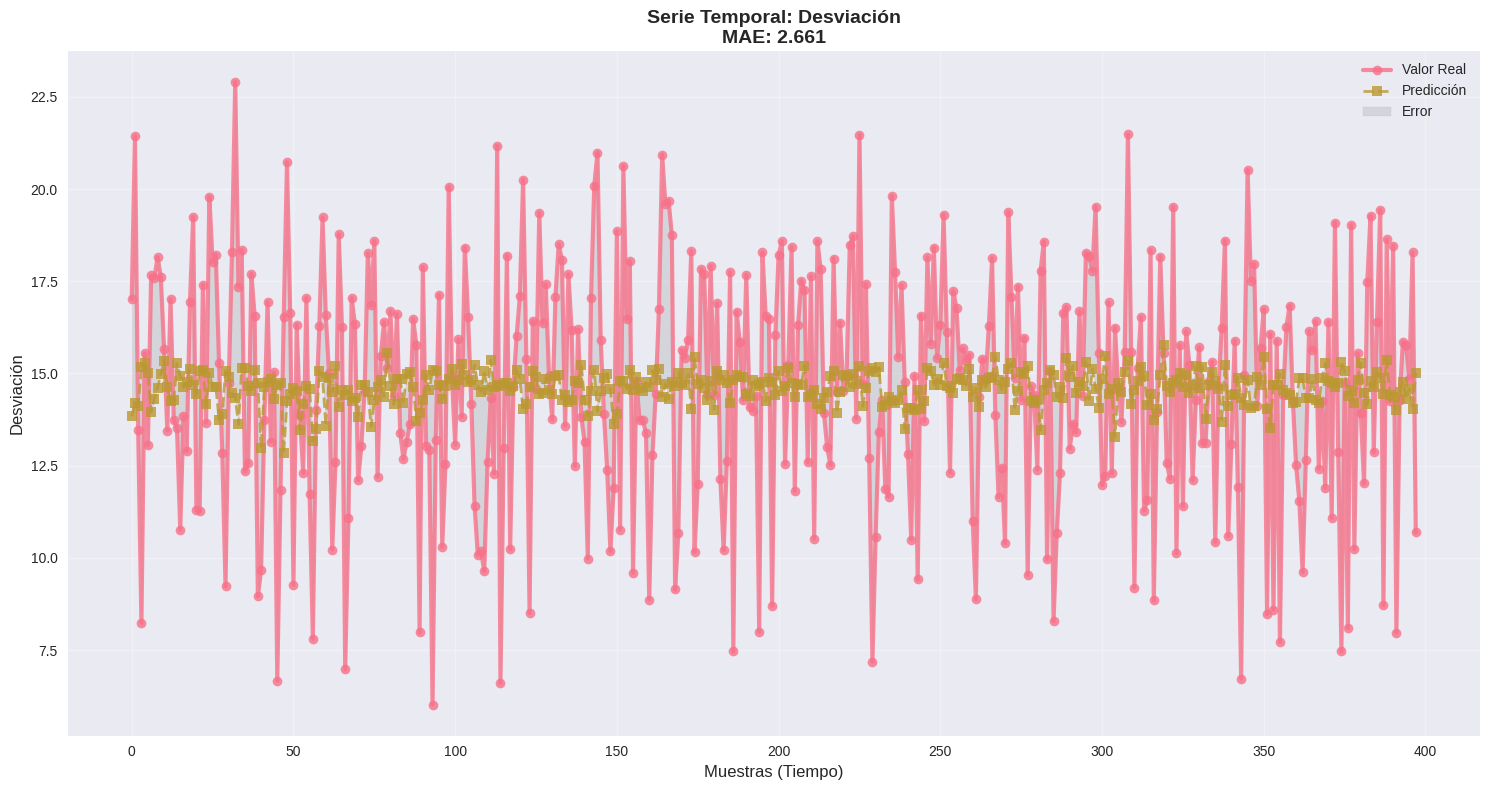

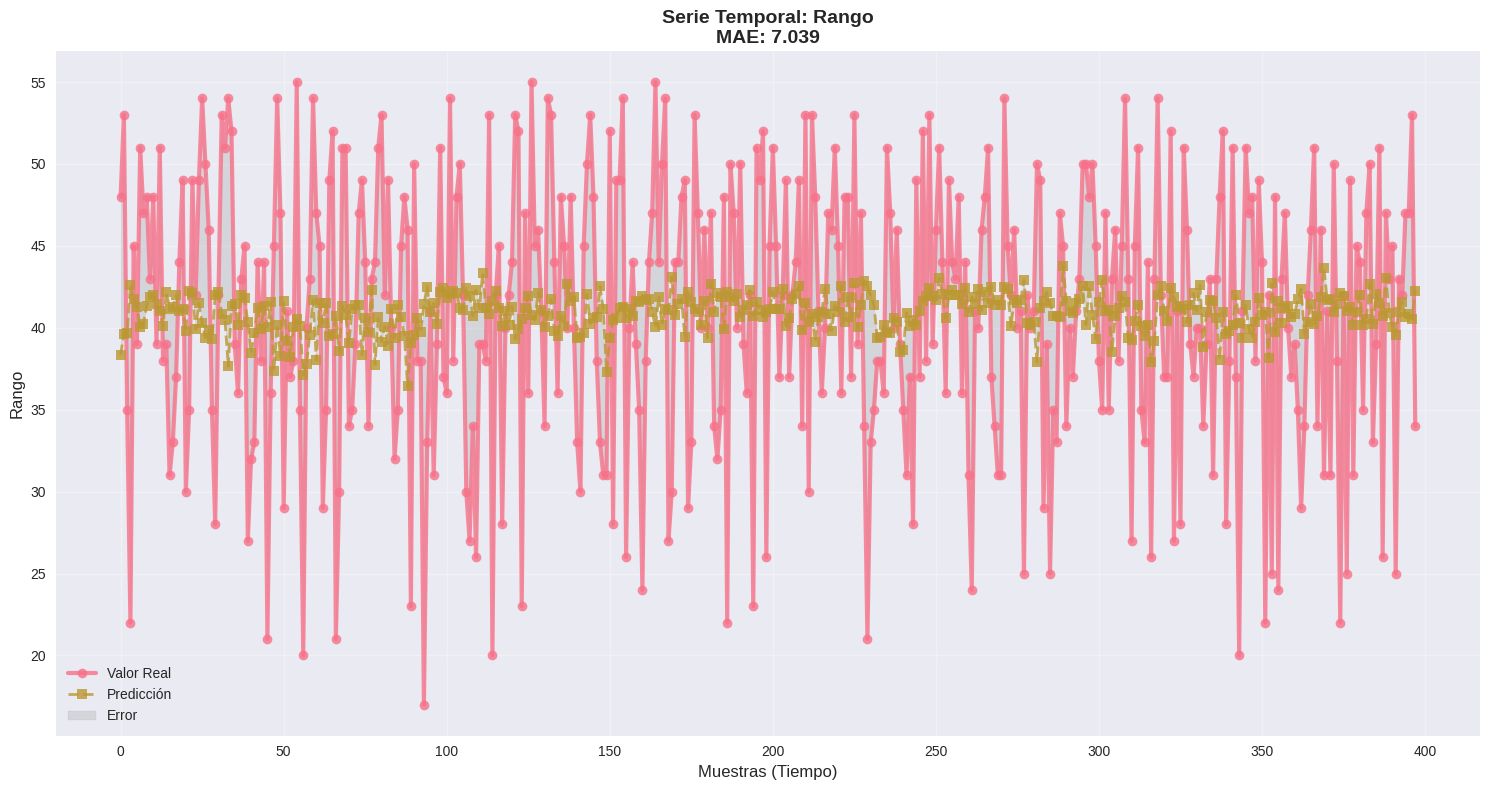

In [92]:
def plot_time_series_predictions(y_true, y_pred, feature_index=0, feature_name='Suma Total'):
    plt.figure(figsize=(15, 8))
    
    # Crear índices de tiempo
    time_index = range(len(y_true))
    
    plt.plot(time_index, y_true[:, feature_index], 
             label='Valor Real', linewidth=3, alpha=0.8, marker='o')
    plt.plot(time_index, y_pred[:, feature_index], 
             label='Predicción', linewidth=2, alpha=0.8, marker='s', linestyle='--')
    
    plt.fill_between(time_index, 
                    y_true[:, feature_index], 
                    y_pred[:, feature_index],
                    alpha=0.2, color='gray', label='Error')
    
    plt.title(f'Serie Temporal: {feature_name}\nMAE: {mean_absolute_error(y_true[:, feature_index], y_pred[:, feature_index]):.3f}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Muestras (Tiempo)', fontsize=12)
    plt.ylabel(feature_name, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usar para diferentes características
for i, feature in enumerate(feature_names[:4]):  # Primeras 4 características
    plot_time_series_predictions(y_test, y_pred_ensemble, i, feature)

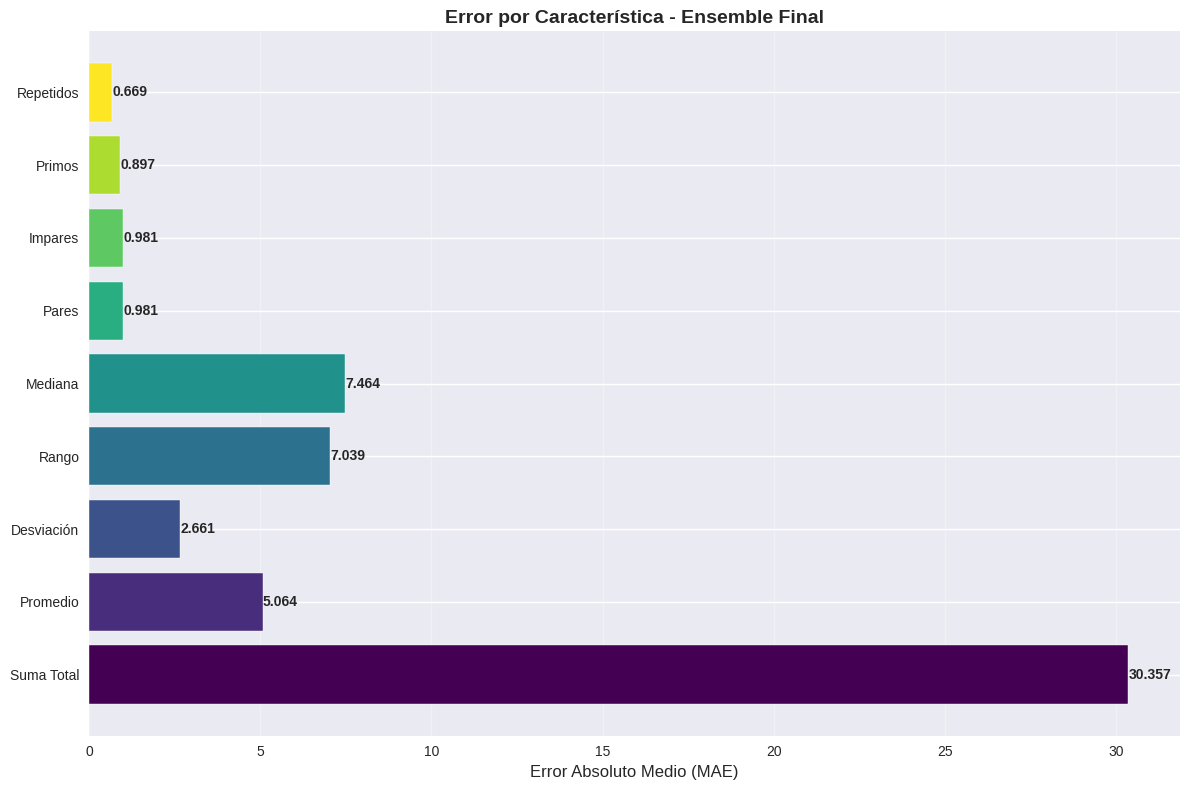

In [93]:
def plot_error_matrix(y_true, y_pred, feature_names):
    errors = np.abs(y_true - y_pred)
    mean_errors = np.mean(errors, axis=0)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(feature_names, mean_errors, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(feature_names))))
    
    plt.xlabel('Error Absoluto Medio (MAE)', fontsize=12)
    plt.title('Error por Característica - Ensemble Final', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores
    for i, (bar, error) in enumerate(zip(bars, mean_errors)):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{error:.3f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_error_matrix(y_test, y_pred_ensemble, feature_names)

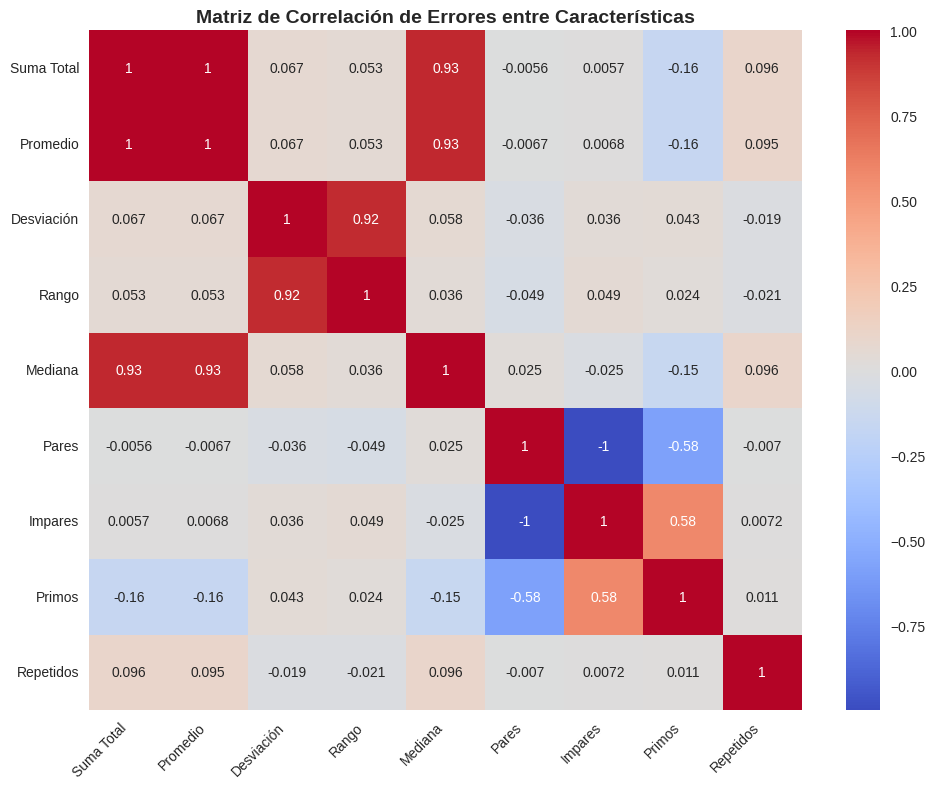

In [94]:
def plot_error_correlation(y_true, y_pred, feature_names):
    errors = y_true - y_pred
    error_corr = np.corrcoef(errors.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_corr, annot=True, cmap='coolwarm', center=0,
                xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Matriz de Correlación de Errores entre Características', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_error_correlation(y_test, y_pred_ensemble, feature_names)

In [95]:
def interactive_time_series(y_true, y_pred, feature_names):
    fig = make_subplots(rows=3, cols=3, subplot_titles=feature_names)
    
    for i, feature in enumerate(feature_names):
        row = i // 3 + 1
        col = i % 3 + 1
        
        fig.add_trace(
            go.Scatter(x=list(range(len(y_true))), y=y_true[:, i],
                      name='Real', mode='lines+markers', line=dict(width=3)),
            row=row, col=col
        )
        
        fig.add_trace(
            go.Scatter(x=list(range(len(y_pred))), y=y_pred[:, i],
                      name='Predicción', mode='lines+markers', line=dict(dash='dash', width=2)),
            row=row, col=col
        )
    
    fig.update_layout(height=800, width=1200, 
                     title_text="Predicciones vs Valores Reales - Todas las Características",
                     showlegend=False)
    fig.show()

# interactive_time_series(y_test, y_pred_ensemble, feature_names)

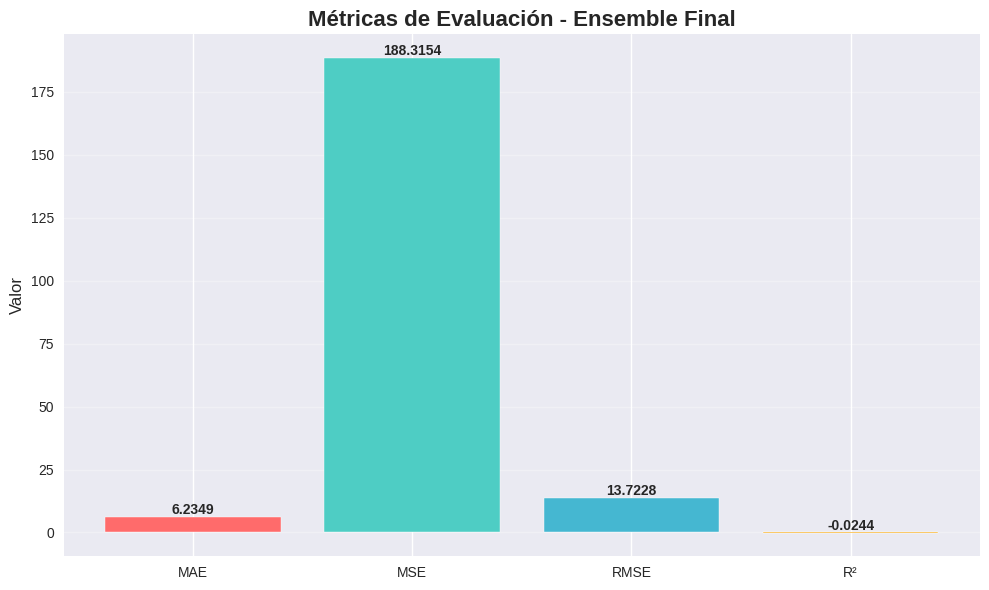

In [97]:
def plot_metrics_summary(y_true, y_pred, model_name):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred)
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics.keys(), metrics.values(), 
                 color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602'])
    
    ax.set_title(f'Métricas de Evaluación - {model_name}', fontsize=16, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars, metrics.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
               f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_metrics_summary(y_test, y_pred_ensemble, 'Ensemble Final')

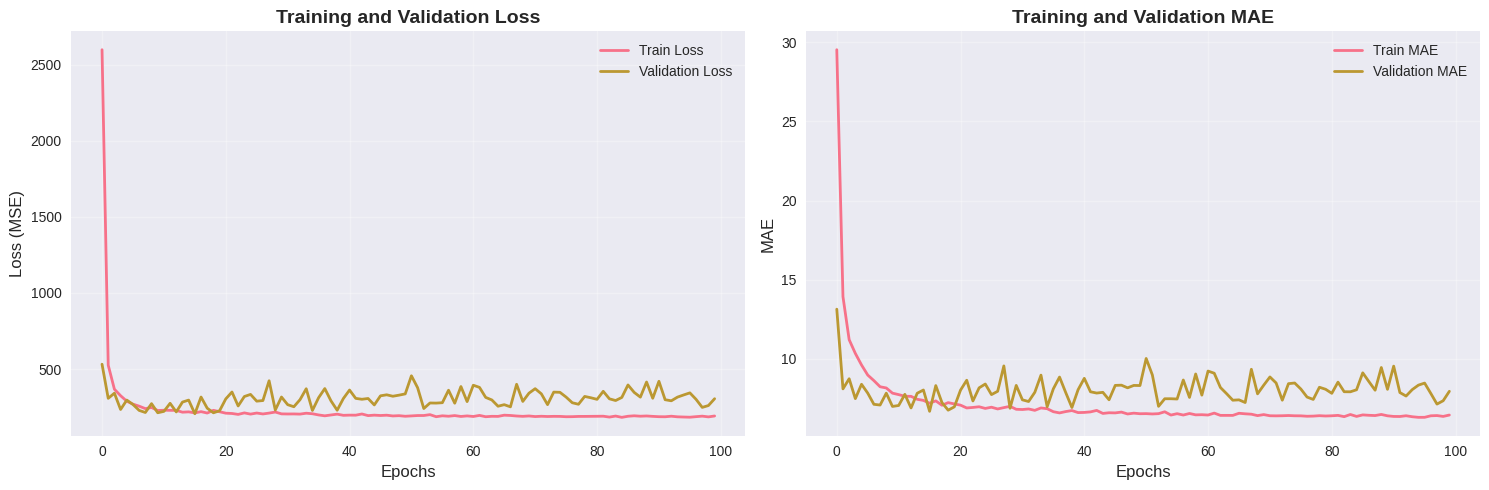

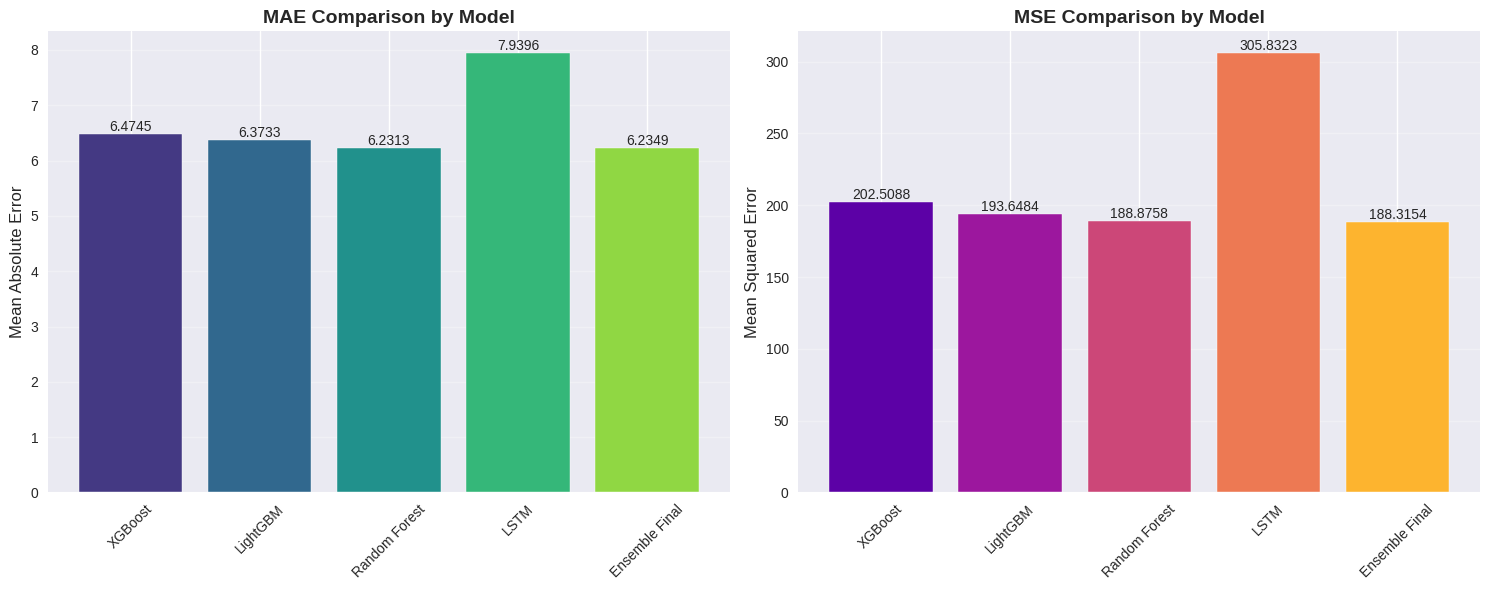

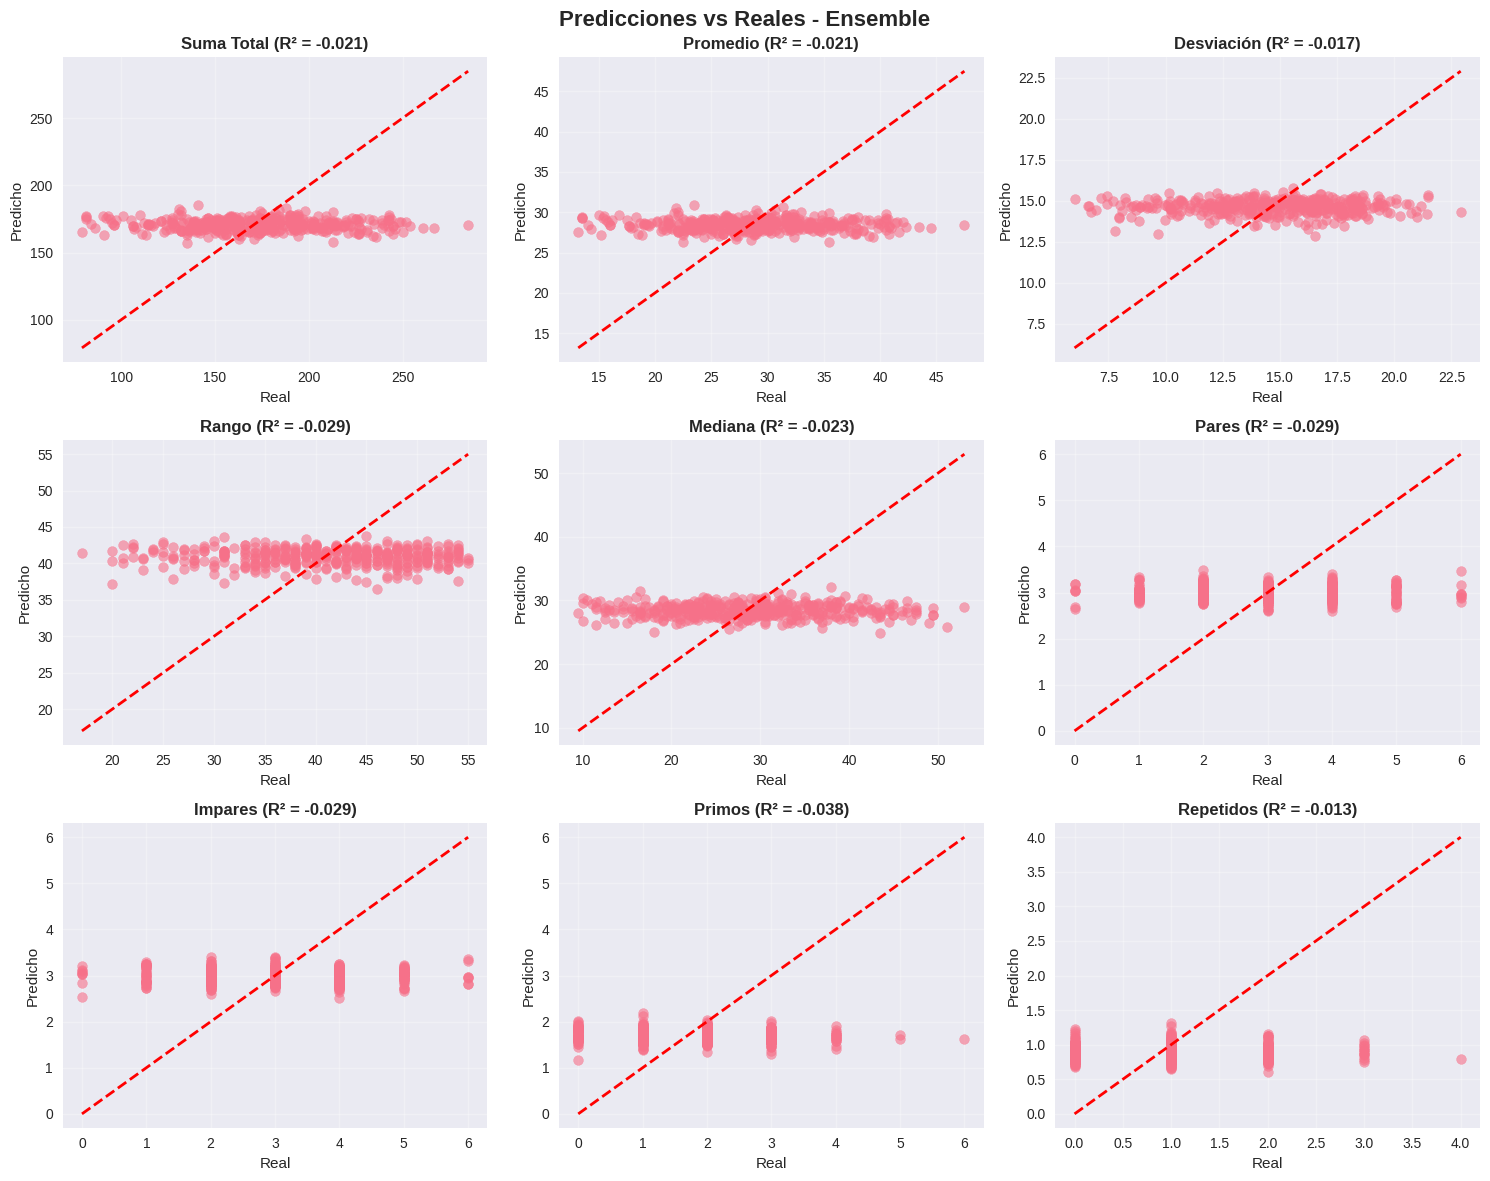

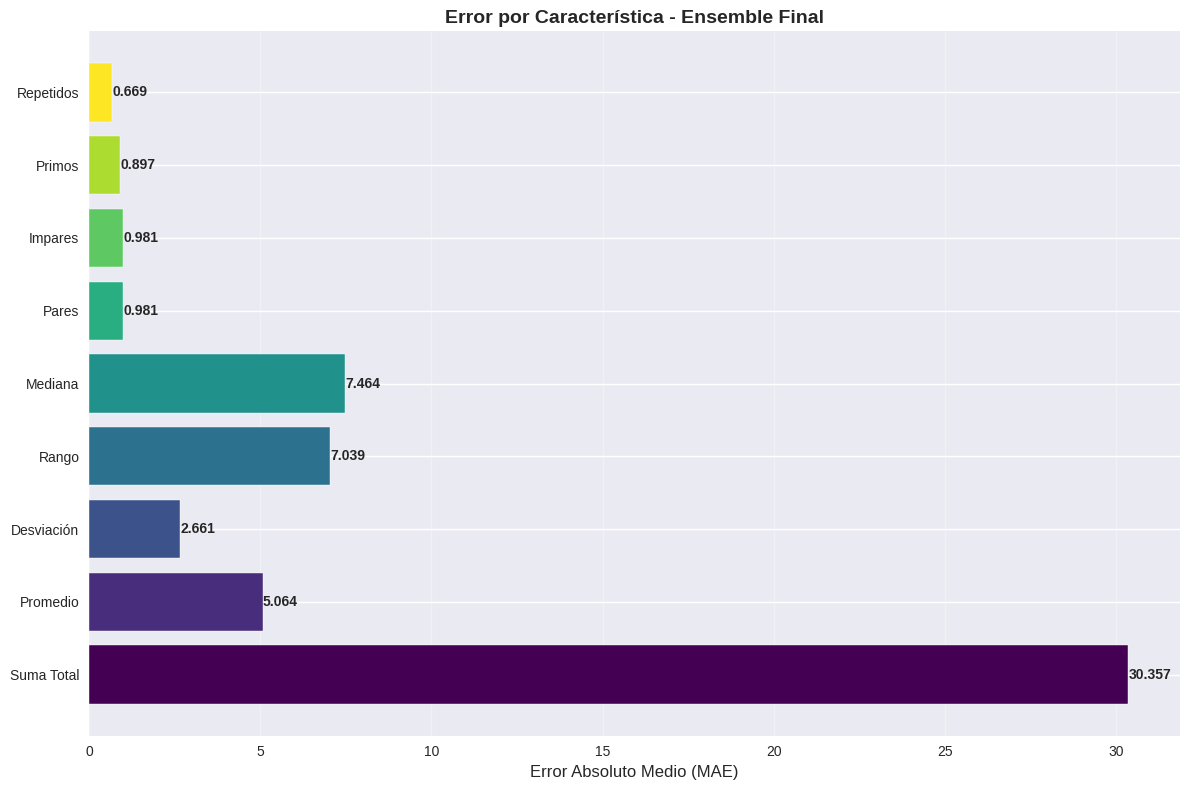

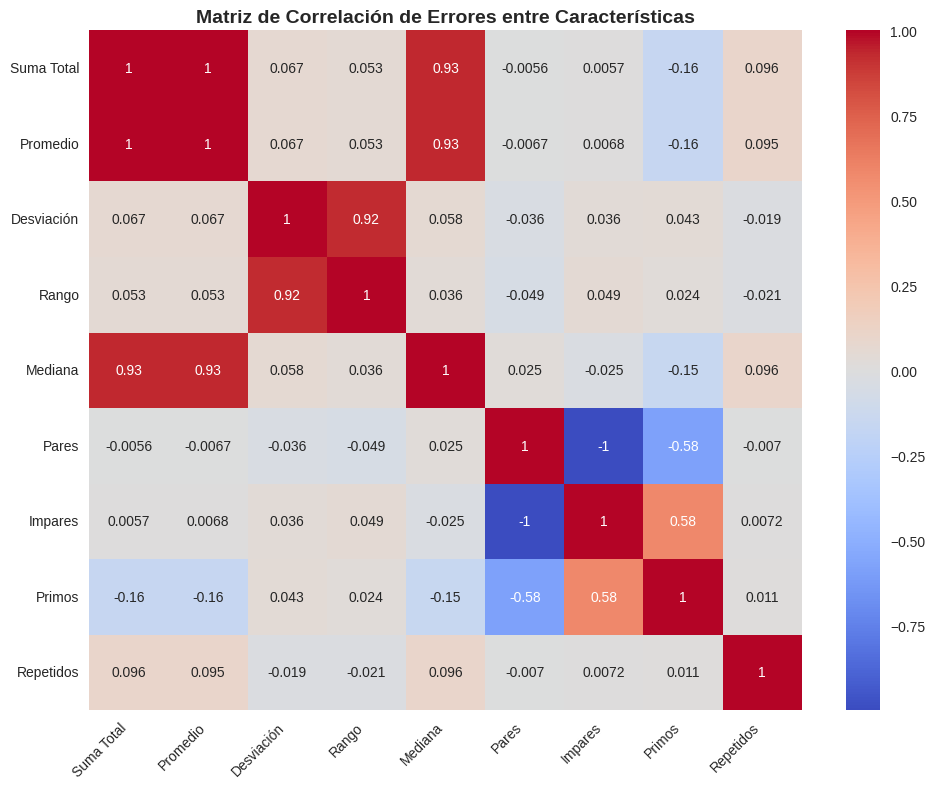

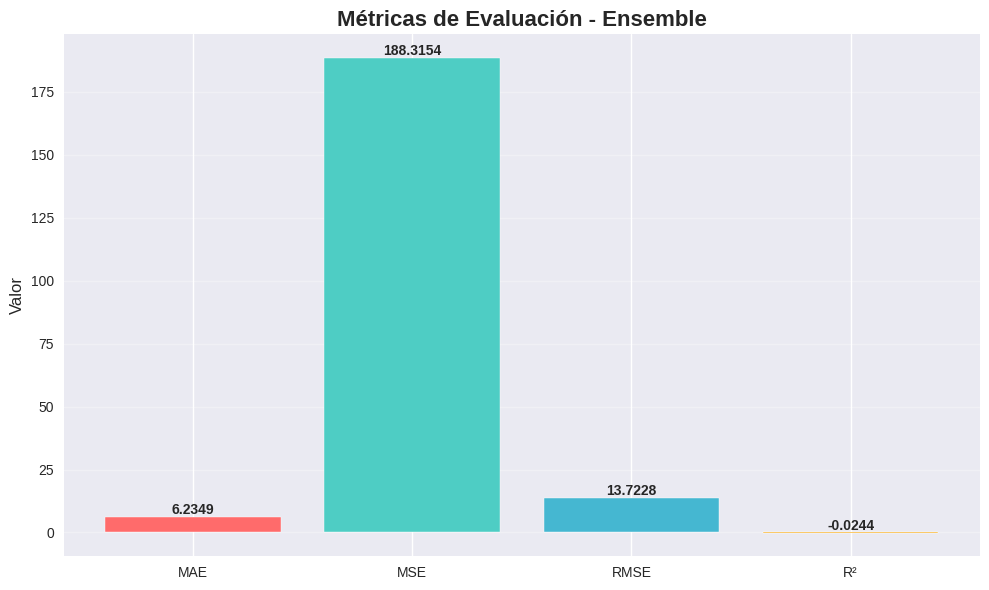

In [98]:
def save_all_plots(y_test, y_pred, history, models_performance, feature_names):
    """Guarda todas las gráficas en alta calidad"""
    
    plots = {
        'training_history.png': lambda: plot_training_history(history),
        'model_comparison.png': lambda: plot_model_comparison(models_performance),
        'predictions_vs_real.png': lambda: plot_predictions_vs_real(y_test, y_pred, 'Ensemble', feature_names),
        'error_matrix.png': lambda: plot_error_matrix(y_test, y_pred, feature_names),
        'error_correlation.png': lambda: plot_error_correlation(y_test, y_pred, feature_names),
        'metrics_summary.png': lambda: plot_metrics_summary(y_test, y_pred, 'Ensemble')
    }
    
    for filename, plot_func in plots.items():
        try:
            plot_func()
            plt.savefig(f'results/{filename}', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error guardando {filename}: {e}")

# Crear carpeta de resultados
import os
os.makedirs('results', exist_ok=True)

# Guardar todo
save_all_plots(y_test, y_pred_ensemble, history, models_performance, feature_names)

In [99]:
def predecir_proximo_sorteo_ensemble(melate_df, ensemble, scaler, look_back=14):
    """
    Predice las características del próximo sorteo usando el ensemble
    """
    # 1. Obtener los últimos 'look_back' sorteos
    ultimos_sorteos = melate_df[['R1', 'R2', 'R3', 'R4', 'R5', 'R6']].tail(look_back)
    
    # 2. Normalizar los datos
    ultimos_normalizados = scaler.transform(ultimos_sorteos)
    
    # 3. Preparar datos para diferentes modelos
    X_2d = ultimos_normalizados.reshape(1, -1)  # Para tree models: (1, 14*6 = 84)
    X_3d = ultimos_normalizados.reshape(1, look_back, 6)  # Para LSTM: (1, 14, 6)
    
    # 4. Predecir con el ensemble
    prediccion = ensemble.predict(X_2d, X_3d)
    
    return prediccion[0]  # Devolver la predicción única

# Obtener la predicción
prediccion_proximo = predecir_proximo_sorteo_ensemble(melate_df, ensemble, scaler)

print("🎯 PREDICCIÓN DEL PRÓXIMO SORTEO:")
print("=" * 50)
for i, (caracteristica, valor) in enumerate(zip(feature_names, prediccion_proximo)):
    print(f"{caracteristica:15}: {valor:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
🎯 PREDICCIÓN DEL PRÓXIMO SORTEO:
Suma Total     : 163.89
Promedio       : 27.43
Desviación     : 14.53
Rango          : 40.88
Mediana        : 26.32
Pares          : 2.71
Impares        : 3.28
Primos         : 1.65
Repetidos      : 1.03


In [104]:
def generar_numeros_sugeridos(prediccion, n_numeros=10):
    """
    Genera números sugeridos basado en las características predichas
    """
    # Extraer características clave
    suma_esperada = prediccion[0]
    promedio_esperado = prediccion[1]
    n_pares = int(round(prediccion[5]))
    n_impares = 6 - n_pares
    n_primos = int(round(prediccion[7]))
    
    print(f"\n🎲 SUGERENCIAS DE NÚMEROS:")
    print("=" * 50)
    print(f"• Suma objetivo: ~{suma_esperada:.0f}")
    print(f"• Pares/Impares: {n_pares}/{n_impares}")
    print(f"• Primos: {n_primos}")
    
    # Aquí podrías implementar lógica más sofisticada para generar números
    # basado en estas características
    
    return {
        'suma_objetivo': suma_esperada,
        'pares': n_pares,
        'impares': n_impares,
        'primos': n_primos
    }

# Generar sugerencias
sugerencias = generar_numeros_sugeridos(prediccion_proximo)


🎲 SUGERENCIAS DE NÚMEROS:
• Suma objetivo: ~164
• Pares/Impares: 3/3
• Primos: 2


In [105]:
def comparar_con_historial(melate_df, prediccion, n_sorteos=5):
    """
    Compara la predicción con sorteos recientes
    """
    print(f"\n📊 COMPARACIÓN CON ÚLTIMOS {n_sorteos} SORTEOS:")
    print("=" * 60)
    
    ultimos = melate_df.tail(n_sorteos)
    
    for i, (idx, row) in enumerate(ultimos.iterrows()):
        # Calcular características reales del sorteo
        numeros = [row['R1'], row['R2'], row['R3'], row['R4'], row['R5'], row['R6']]
        suma_real = sum(numeros)
        promedio_real = np.mean(numeros)
        
        print(f"Sorteo {row['CONCURSO']}:")
        print(f"  Suma: {suma_real:3.0f} (pred: {prediccion[0]:3.0f}) | "
              f"Promedio: {promedio_real:4.1f} (pred: {prediccion[1]:4.1f})")
        
        if i == n_sorteos - 1:
            print(f"  → PRÓXIMO: Suma ~{prediccion[0]:.0f}, Promedio ~{prediccion[1]:.1f}")

# Comparar
comparar_con_historial(melate_df, prediccion_proximo)


📊 COMPARACIÓN CON ÚLTIMOS 5 SORTEOS:
Sorteo 2099:
  Suma: 186 (pred: 164) | Promedio: 31.0 (pred: 27.4)
Sorteo 2098:
  Suma: 214 (pred: 164) | Promedio: 35.7 (pred: 27.4)
Sorteo 2097:
  Suma: 232 (pred: 164) | Promedio: 38.7 (pred: 27.4)
Sorteo 2096:
  Suma: 114 (pred: 164) | Promedio: 19.0 (pred: 27.4)
Sorteo 2095:
  Suma: 147 (pred: 164) | Promedio: 24.5 (pred: 27.4)
  → PRÓXIMO: Suma ~164, Promedio ~27.4


In [106]:
def guardar_prediccion(prediccion, melate_df):
    """
    Guarda la predicción para futura comparación
    """
    prediccion_df = pd.DataFrame([prediccion], columns=feature_names)
    prediccion_df['timestamp'] = pd.Timestamp.now()
    prediccion_df['ultimo_sorteo'] = melate_df['CONCURSO'].iloc[-1]
    
    # Guardar en CSV
    try:
        historial_pred = pd.read_csv('predicciones_historial.csv')
        historial_pred = pd.concat([historial_pred, prediccion_df], ignore_index=True)
    except FileNotFoundError:
        historial_pred = prediccion_df
    
    historial_pred.to_csv('predicciones_historial.csv', index=False)
    print(f"\n💾 Predicción guardada para seguimiento futuro")

# Guardar predicción
guardar_prediccion(prediccion_proximo, melate_df)


💾 Predicción guardada para seguimiento futuro
